In [1]:
import pandas as pd
import re
import os
from spherical_fields import *
import units 
import spherical_fields
import field_regularizer
import mhd_system
from settings import Settings
import matplotlib.pyplot as plt
import importlib
import astropy.units
importlib.reload(mhd_system)
importlib.reload(field_regularizer)

def read_lesur(filename):
    global data
    data = pd.read_csv(filename, skiprows=6, delimiter="\t+", engine='python')
    data.columns = [x.split(" ")[0] for x in data.columns]
    thetas = data.theta.to_numpy()
    
    cs = ScalarField(np.sqrt((data.P/data.rho).to_numpy()), -1/2, thetas)
    beta, Lambda_a_0, Rm_0 = [float(x) for x in re.findall("=(inf|[^-]+)", filename)]
    lambda_ = 3
    parameter_rep = np.concatenate([data["rho"]   , 
                                    data["vr"]    , 
                                    data["vtheta"], 
                                    data["vphi"]  ,
                                    data["Btheta"],
                                    data["Bphi"], 
                                   ])
    
    regularized_fields = field_regularizer.field_regularizer(parameter_rep, thetas, cs, beta)
    return mhd_system.mhd_system(cs, Lambda_a_0, Rm_0, lambda_), regularized_fields

#for file in os.listdir("../PPDwind"):
#    if ".dat" in file:
#        mhd_sim, regularized_fields = read_lesur("../PPDwind/" + file)
        #plt.plot(theta,cs2.v)
        #plt.semilogy(rho.theta_grid,rho.v)
        #plt.xlim(np.pi/2-0.01, np.pi/2+0.01)
#        break
file = "beta=1.0e+05-Am=1-Rm=inf.dat"
mhd_sim, regularized_fields = read_lesur("../PPDwind/" + file)

[0.09999354 0.09999354 0.09999354 ... 0.09999354 0.09999354 0.09999354]


/mnt/c/Users/rasmu/Dropbox/Uni/PUK/Code/mhd_system.py:26: RuntimeWarning: overflow encountered in exp
  Lambda_A = ScalarField(Lambda_a_0*np.exp((z/(lambda_*h))**4), -1, theta_grid, prescription="cylindrical")


In [2]:
def plot_system(rho, v, B, axes):
    rho_ax, v_ax, B_ax = axes
    rho_ax.plot(rho.theta_grid, rho.v, color="k")
    rho_ax.set_title("rho")
    rho_ax.grid()
    v_ax.plot(v.theta_grid, v.v_r, color="blue")
    v_ax.plot(v.theta_grid, v.v_theta, color="red")
    v_ax.plot(v.theta_grid, v.v_phi, color="green")
    v_ax.set_title("v")
    v_ax.grid()
    v_ax.legend(["r", "theta", "phi"])
    B_ax.plot(B.theta_grid, B.v_r, color="blue")
    B_ax.plot(B.theta_grid, B.v_theta, color="red")
    B_ax.plot(B.theta_grid, B.v_phi, color="green")
    B_ax.set_title("B")
    B_ax.grid()
    B_ax.legend(["r", "theta", "phi"])

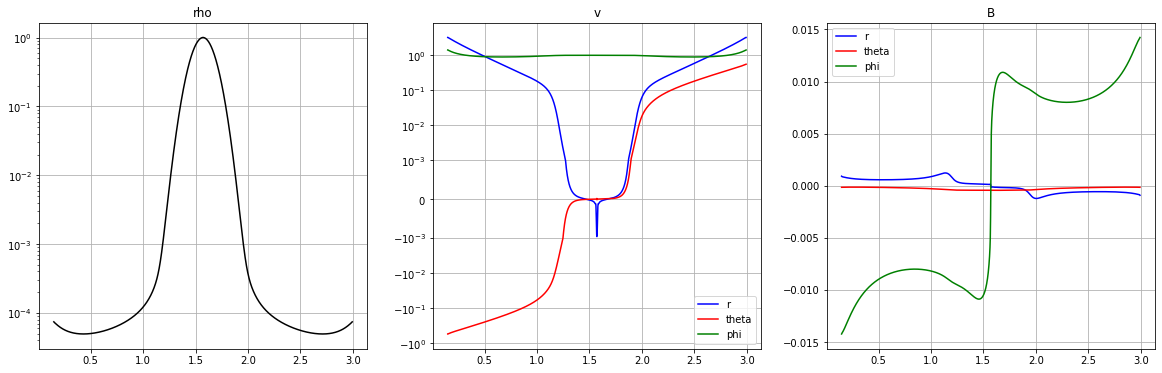

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
plot_system(regularized_fields.rho, regularized_fields.v,
            regularized_fields.B, axes)
axes[0].set_yscale("log")
axes[1].set_yscale("symlog", linthresh=0.001)
#axes[1].set_xlim(np.pi/2-0.1, np.pi/2+0.1)

In [858]:
import scipy.integrate
np.seterr("warn", over="ignore", under="ignore")

#pos_dust (r, theta)
#vel_dust (r, theta, phi)
def acceleration(t, state, dust_size, v, rho, cs):   
    r, theta = state[:2]
    rdot, thetadot, phidot = state[2:]
    # fomulas taken from https://en.wikipedia.org/wiki/Vector_fields_in_cylindrical_and_spherical_coordinates
    carthesian_to_spherical = lambda theta, vec: np.array([ 
            np.sin(theta) * vec[0] + np.cos(theta) * vec[2],
            np.cos(theta) * vec[0] - np.sin(theta) * vec[2],
            vec[1],
        ])
    spherical_to_carthesian = lambda theta, vec: np.array([ 
            np.sin(theta) * vec[0] + np.cos(theta) * vec[1],
            vec[2],
            np.cos(theta) * vec[0] - np.sin(theta) * vec[1],
        ])
    v_cart_dust = spherical_to_carthesian(theta, [rdot, r*thetadot, r*np.sin(theta)*phidot])
    v_cart_gas = spherical_to_carthesian(theta, v.at_coord(r,theta))

    ## Drag acceleration
    g_per_cm2 = units.units.kg*1e-3*(units.units.m*1e-2)**-2
    dust_size = dust_size * g_per_cm2 # particle size * density measured in g/cm^2
    ts = dust_size / (rho * cs).at_coord(r,theta)
    acc_cart_drag = (v_cart_gas - v_cart_dust) / ts
    acc_pol_drag = carthesian_to_spherical(theta, acc_cart_drag)

    ## Gravitational acceleration (in spherical coords)
    acc_pol_G = np.array([-units.constants.GM/r**2,np.zeros_like(r),np.zeros_like(r)])

    ## Fictitious accelerations (in spherical coords, coordinate rotating with particle)
    acc_ext = acc_pol_drag + acc_pol_G
    acc_relative = np.array([acc_ext[0] + r*thetadot**2+r*(np.sin(theta)*phidot)**2,
                             acc_ext[1]/r-2*rdot*thetadot/r+np.sin(theta)*np.cos(theta)*phidot**2,
                             1/(r*np.sin(theta))*(acc_ext[2]-2*rdot*phidot*np.sin(theta)-2*r*thetadot*phidot*np.cos(theta))])
    #print(x_pos, omega)
    #print("G: \n", acc_pol_G, "\ndrag: \n", acc_pol_drag, "\ncent: \n", acc_pol_cent)
    #call()
    return np.vstack([rdot, thetadot, acc_relative])

def integrate_streamline(r0, theta0, dust_size, v, rho, cs):   
    stopper1    = lambda t, x: np.abs((np.tan(np.pi/2-x[1]))*x[0] - 60)
    stopper2    = lambda t, x: min(x[1]-v.theta_grid[0], v.theta_grid[-1]-x[1]) - 0.04
    stopper3    = lambda t, x: x[0] - 0.01
    stopper1.terminal = True
    stopper2.terminal = True
    stopper3.terminal = True
    res = scipy.integrate.solve_ivp(lambda t,state: acceleration(t, state, dust_size, v, rho, cs), t_span=(0,10e10), y0=np.array([r0, theta0, *v.at_coord(r0, theta0)]), method="BDF", vectorized=True, events=[stopper1, stopper2, stopper3])
    return res

In [860]:
for dustsize in np.linspace(0.1, 1, 10):
    print(dustsize)
    res = integrate_streamline(1, np.pi/2+0.02, dustsize, regularized_fields.v, regularized_fields.rho, mhd_sim.cs)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0


(0.0, 10000.0)

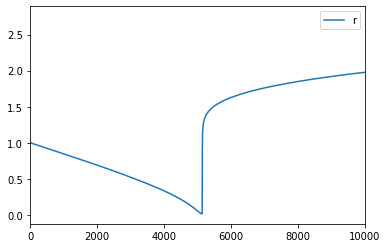

In [869]:
plt.plot(res.t,res.y[0])
plt.legend(["r", "theta", "vdot", "thetadot", "phidot"])
plt.xlim(0,1e4)

In [849]:
def plot_vector_field(field, extent=(0.1, 2, -1, 1), resolution=(100,100), color_scale=(-1.5, 1.5)):
    v = regularized_fields.v
    Rs, zs = np.meshgrid(np.linspace(*extent[:2],resolution[0]), np.linspace(*extent[2:],resolution[1]))
    thetas = np.pi/2-np.arctan(zs/Rs)
    rs   = np.hypot(Rs, zs)
    dr   = np.interp(thetas, v.theta_grid, v.v_r, left=np.nan, right=np.nan)*rs**v.a
    dt   = np.interp(thetas, v.theta_grid, v.v_theta, left=np.nan, right=np.nan)*rs**v.a
    dphi = np.interp(thetas, v.theta_grid, v.v_phi, left=np.nan, right=np.nan)*rs**v.a
    cs   = np.interp(thetas, v.theta_grid, mhd_sim.cs.v, left=np.nan, right=np.nan)*rs**mhd_sim.cs.a
    plt.streamplot(Rs, zs, dr * np.sin(thetas) + dt * np.cos (thetas), dr * np.cos(thetas) - dt * np.sin(thetas), color="w", linewidth=1)
    plt.imshow(np.log10(np.sqrt(dr**2+dt**2)/cs),extent=extent, norm=matplotlib.colors.Normalize(*color_scale), cmap="seismic")
    plt.colorbar(ticks=np.arange(*color_scale, 0.3), format="$%.1f$")

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0


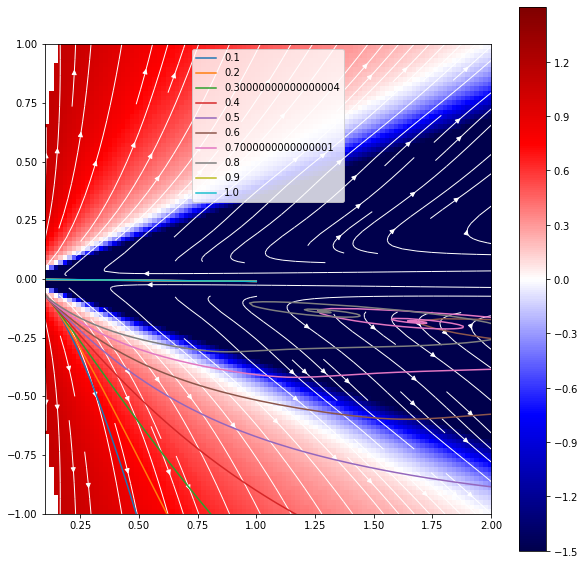

In [872]:
plt.figure(figsize=(10,10))
plot_vector_field(v,extent=(0.1, 2, -1, 1))
for dustsize in np.linspace(0.1, 1, 10):
    print(dustsize)
    res = integrate_streamline(1, np.pi/2+0.01, dustsize, regularized_fields.v, regularized_fields.rho, mhd_sim.cs)
    plt.plot(np.cos(np.pi/2-res.y[1])*res.y[0], np.sin(np.pi/2-res.y[1])*res.y[0])
plt.axis((0.1, 2, -1, 1))
plt.legend(np.linspace(0.1, 1, 10))

#### res.y.shape

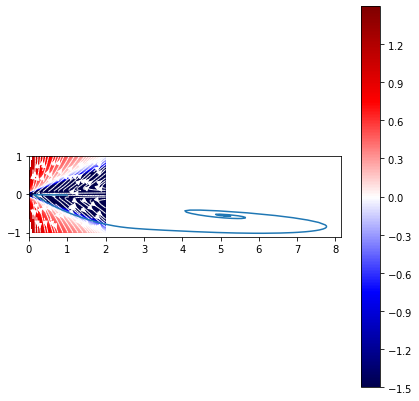

In [835]:
import matplotlib.colors
v = regularized_fields.v
plt.figure(figsize=(7,7))
Rs, zs = np.meshgrid(np.linspace(0.1,2,200), np.linspace(-1,1,200))
thetas = np.pi/2-np.arctan(zs/Rs)
rs   = np.hypot(Rs, zs)
dr   = np.interp(thetas, v.theta_grid, v.v_r, left=np.nan, right=np.nan)*rs**v.a
dt   = np.interp(thetas, v.theta_grid, v.v_theta, left=np.nan, right=np.nan)*rs**v.a
dphi = np.interp(thetas, v.theta_grid, v.v_phi, left=np.nan, right=np.nan)*rs**v.a
cs   = np.interp(thetas, v.theta_grid, mhd_sim.cs.v, left=np.nan, right=np.nan)*rs**mhd_sim.cs.a
plt.streamplot(Rs, zs, dr * np.sin(thetas) + dt * np.cos (thetas), dr * np.cos(thetas) - dt * np.sin(thetas), color="w", linewidth=1)
plt.imshow(np.log10(np.sqrt(dr**2+dt**2)/cs),extent=(0,2,-1,1), norm=matplotlib.colors.Normalize(-1.5,1.5), cmap="seismic")
plt.colorbar(ticks=np.arange(-1.5, 1.5, 0.3), format="$%.1f$")
plt.plot(np.cos(np.pi/2-res.y[1])*res.y[0], np.sin(np.pi/2-res.y[1])*res.y[0])
#plt.axis((0,2,-1,1))

In [610]:
v.at_coord(*res.y[:2,-1]), res.y[2:,-1]*np.array([1, res.y[0,-1], res.y[0,-1]*np.sin(res.y[1,-1])])

(array([0.34622423, 0.06247511, 0.15634847]),
 array([0.3462246 , 0.06247591, 0.15634926]))

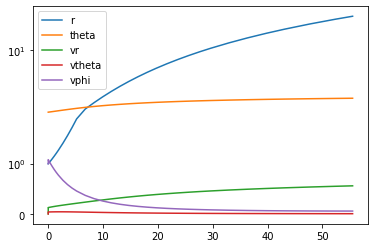

In [551]:
plt.plot(res.t,np.abs(res.y.T))
#plt.plot(res.t,regularized_fields.v.at_coord(*res.y[:2]).T)
plt.legend(["r", "theta", "vr", "vtheta", "vphi", "gas_vr", "gas_vtheta", "gas_vphi"])
plt.yscale("symlog")

(0.0, 1.0)

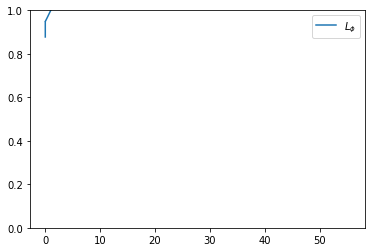

In [552]:
plt.plot(res.t,res.y[0]*np.sqrt((res.y[0]*res.y[3])**2+(res.y[0]*np.sin(res.y[1])*res.y[4])**2))
#plt.plot(res.t,res.y[0]*res.y[3])
plt.legend([r"$L_\phi$",r"$L_{\theta}$"])
plt.ylim(0,1)

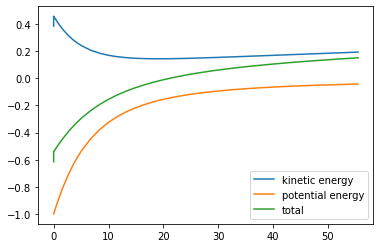

In [553]:
Ekin = (res.y[2]**2+(res.y[0]*res.y[3])**2+(res.y[0]*np.sin(res.y[1])*res.y[4])**2)/2
Epot = -1/res.y[0]
plt.plot(res.t,Ekin)
plt.plot(res.t,Epot)
plt.plot(res.t,Ekin+Epot)
plt.legend(["kinetic energy", "potential energy", "total"])

In [536]:
import scipy.integrate as integrate
plt.figure(figsize=(4,5))

z = np.sin(np.pi/2-res.y[1])*res.y[0]

# Kinetic:
plt.plot(z, np.sum(v.at_coord(*res.y)**2,0)/2, "-.")

# Gravitational:
R = np.cos(np.pi/2-res.y[1])*res.y[0]
plt.plot(z, -1/np.sqrt(R**2+z**2), "-")

# Magnetic:
#kappa = 4*np.pi*
#omega = Omega-
#R = np.cos(np.pi/2-res.y[1])*res.y[0]
#plt.plot(z, -1/np.sqrt(R**2+z**2), "-")

# Thermal:
P_grad = (mhd_sim.cs**2*rho).grad()
integrand = -(P_grad/rho[1:-1]).at_coord(*res.y)
v_eval = v.at_coord(*res.y)
v_unit = v_eval / (v_eval**2).sum(0)**0.5

x = (integrand*v_eval).sum(0)[:-1] * np.diff(res.t)
plt.plot(z[:-1], np.cumsum(x[::-1])[::-1])
plt.xscale("log")
plt.ylim(-1,1)

TypeError: at_coord() takes 3 positional arguments but 6 were given

<Figure size 288x360 with 0 Axes>